In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

sns.set(style="whitegrid")  # optional for nicer plots

# ---------------------------------------------------------------------
# Load data
# ---------------------------------------------------------------------
df = pd.read_csv("Mental Health dataset1.csv")

# quick peek
print(df.shape)
print(df.columns)
df.head()

(261328, 17)
Index(['Gender', 'Country', 'Occupation', 'SelfEmployed', 'FamilyHistory',
       'Treatment', 'DaysIndoors', 'HabitsChange', 'MentalHealthHistory',
       'IncreasingStress', 'MoodSwings', 'SocialWeakness', 'CopingStruggles',
       'WorkInterest', 'SocialWeakness.1', 'MentalHealthInterview',
       'CareOptions'],
      dtype='object')


,Gender,Country,Occupation,SelfEmployed,FamilyHistory,Treatment,DaysIndoors,HabitsChange,MentalHealthHistory,IncreasingStress,MoodSwings,SocialWeakness,CopingStruggles,WorkInterest,SocialWeakness.1,MentalHealthInterview,CareOptions
0,Female,UK,Others,No,Yes,No,15-30 days,No,Yes,Yes,High,No,Yes,Maybe,No,No,No
1,Female,USA,Housewife,No,Yes,No,15-30 days,Maybe,Maybe,Yes,High,Maybe,Yes,Maybe,Maybe,No,Not sure
2,Female,Canada,Others,No,No,Yes,More than 2 months,Maybe,No,No,Medium,No,No,No,No,No,Not sure
3,Female,Canada,Corporate,No,Yes,Yes,Go out Every day,No,Maybe,No,Medium,No,No,Maybe,No,No,Not sure
4,Female,UK,Corporate,No,No,Yes,More than 2 months,Yes,No,Maybe,Medium,Maybe,No,Maybe,Maybe,No,Not sure


In [2]:
# ---------------------------------------------------------------------
# 1. Remove duplicate SocialWeakness column
# ---------------------------------------------------------------------
if "SocialWeakness.1" in df.columns:
    df = df.drop(columns=["SocialWeakness.1"])

# ---------------------------------------------------------------------
# 2. Drop rows with null values in SelfEmployed
# ---------------------------------------------------------------------
df = df.dropna(subset=["SelfEmployed"])

# ---------------------------------------------------------------------
# 3. Keep only countries that have more than one gender represented
# ---------------------------------------------------------------------
gender_counts = df.groupby(["Country", "Gender"]).size().reset_index(name="count")
countries_gender_div = (
    gender_counts.groupby("Country")["Gender"]
    .nunique()
    .reset_index(name="n_genders")
)
valid_countries = countries_gender_div.loc[
    countries_gender_div["n_genders"] > 1, "Country"
]

df = df[df["Country"].isin(valid_countries)].copy()

print("After cleaning:", df.shape)

After cleaning: (236178, 16)


In [3]:
mh_vars = [
    "HabitsChange",
    "MentalHealthHistory",
    "IncreasingStress",
    "SocialWeakness",
    "MoodSwings",
]

def yes_or_maybe_to_1(series):
    return series.astype(str).str.strip().str.lower().isin(["yes", "maybe"]).astype(int)

for col in mh_vars:
    df[col + "_bin"] = yes_or_maybe_to_1(df[col])

In [4]:
days_map = {
    "Go out Every day": 0,
    "1-14 days": 1,
    "15-30 days": 2,
    "31-60 days": 3,
    "More than 2 months": 4,
}

df["DaysIndoors_num"] = df["DaysIndoors"].map(days_map)

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (188942, 22)
Test shape: (47236, 22)


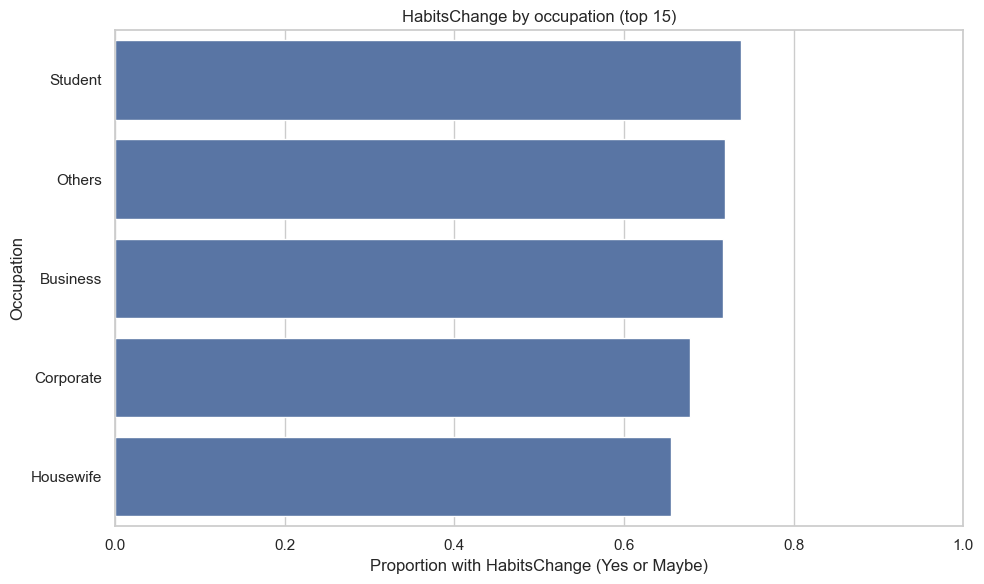

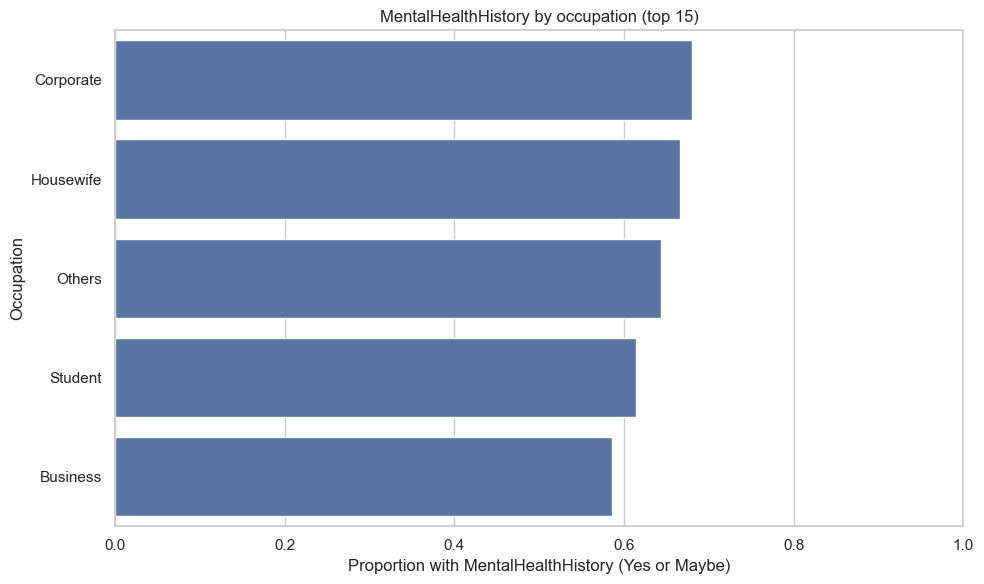

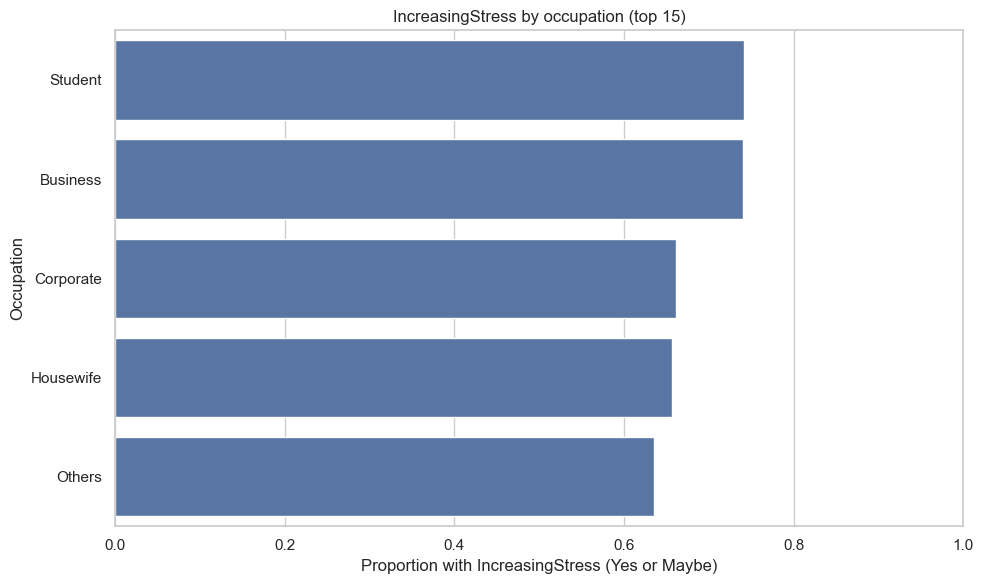

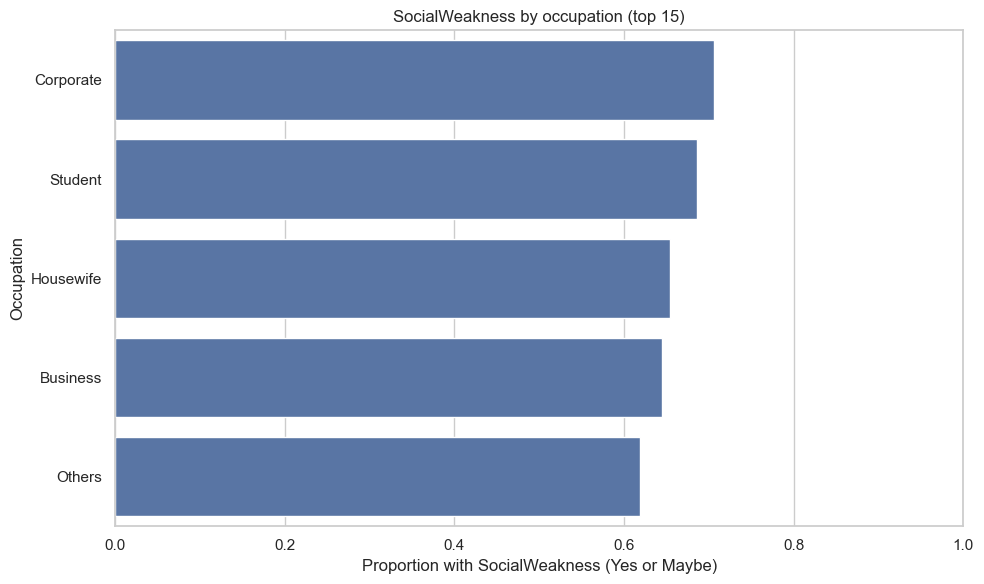

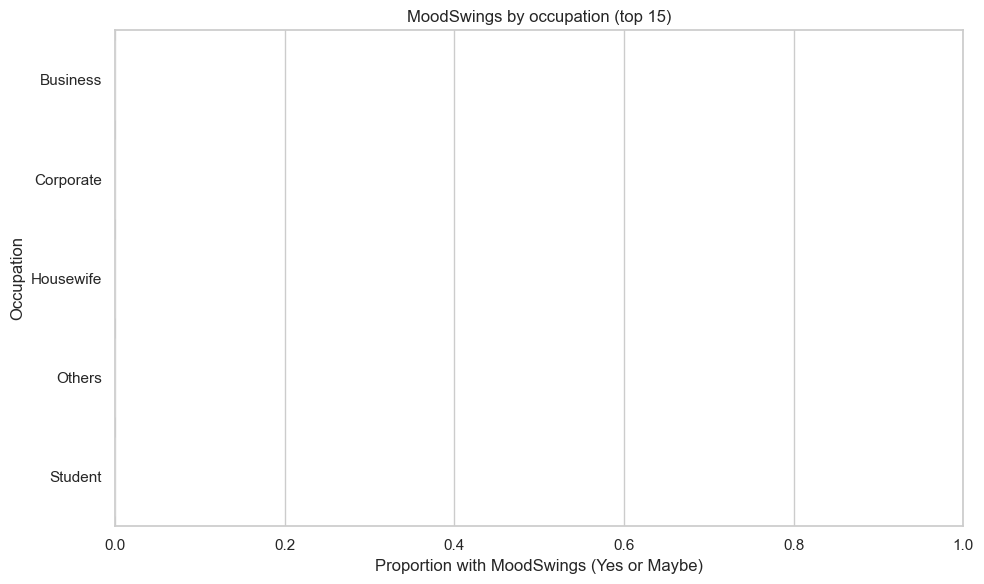

In [6]:
outcome_bins = [v + "_bin" for v in mh_vars]

for outcome, outcome_bin in zip(mh_vars, outcome_bins):
    # proportion with problem by occupation
    occ_stats = (
        df.groupby("Occupation")[outcome_bin]
        .mean()
        .sort_values(ascending=False)
        .head(15)  # top 15 occupations
        .reset_index()
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=occ_stats,
        x=outcome_bin,
        y="Occupation",
    )
    plt.xlabel(f"Proportion with {outcome} (Yes or Maybe)")
    plt.ylabel("Occupation")
    plt.title(f"{outcome} by occupation (top 15)")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

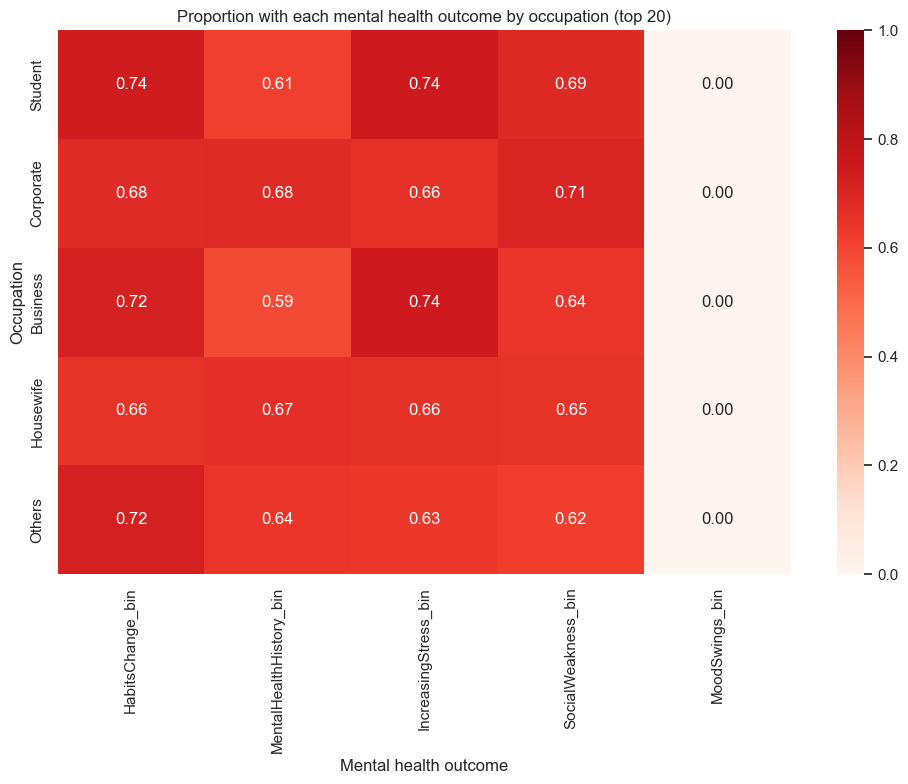

In [7]:
# average of all five outcomes for each occupation
df["AnyIssue_bin_mean"] = df[outcome_bins].mean(axis=1)

top_occ = (
    df.groupby("Occupation")["AnyIssue_bin_mean"]
    .mean()
    .sort_values(ascending=False)
    .head(20)
    .index
)

heat_data = (
    df[df["Occupation"].isin(top_occ)]
    .groupby("Occupation")[outcome_bins]
    .mean()
    .loc[top_occ]  # keep same order
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    heat_data,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    vmin=0,
    vmax=1,
)
plt.title("Proportion with each mental health outcome by occupation (top 20)")
plt.xlabel("Mental health outcome")
plt.ylabel("Occupation")
plt.tight_layout()
plt.show()

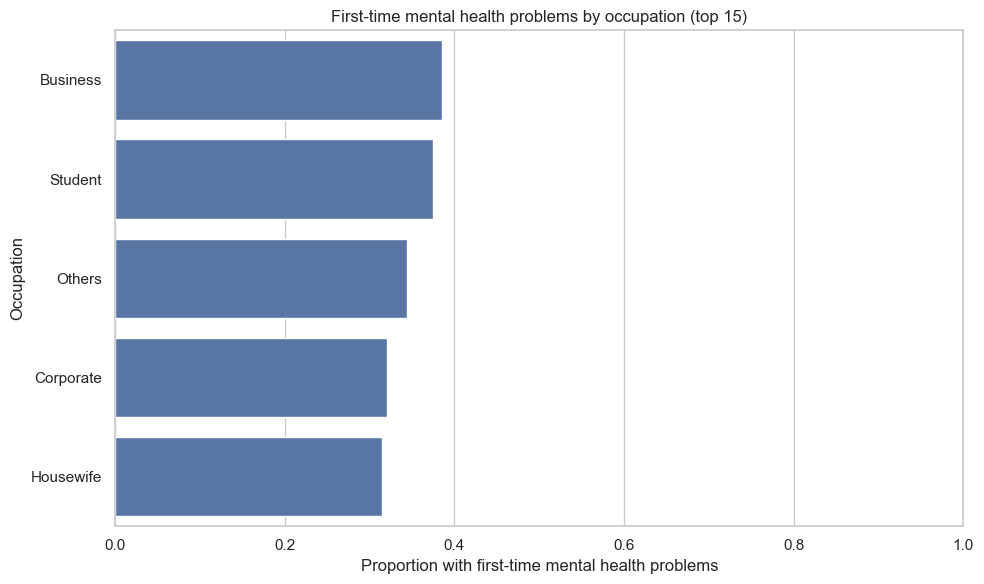

In [8]:
# first-time mental health issues definition
symptom_cols_bin = [
    "HabitsChange_bin",
    "IncreasingStress_bin",
    "SocialWeakness_bin",
    "MoodSwings_bin",
]

no_history = df["MentalHealthHistory_bin"] == 0
any_symptom = df[symptom_cols_bin].sum(axis=1) > 0

df["FirstTimeIssue_bin"] = (no_history & any_symptom).astype(int)

# proportion of first-time issues by occupation
first_time_stats = (
    df.groupby("Occupation")["FirstTimeIssue_bin"]
    .mean()
    .sort_values(ascending=False)
    .head(15)
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=first_time_stats,
    x="FirstTimeIssue_bin",
    y="Occupation",
)
plt.xlabel("Proportion with first-time mental health problems")
plt.ylabel("Occupation")
plt.title("First-time mental health problems by occupation (top 15)")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

/var/folders/v6/dgj3jf5x3n1frx1lx9x5rysw0000gn/T/ipykernel_33623/3555074393.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


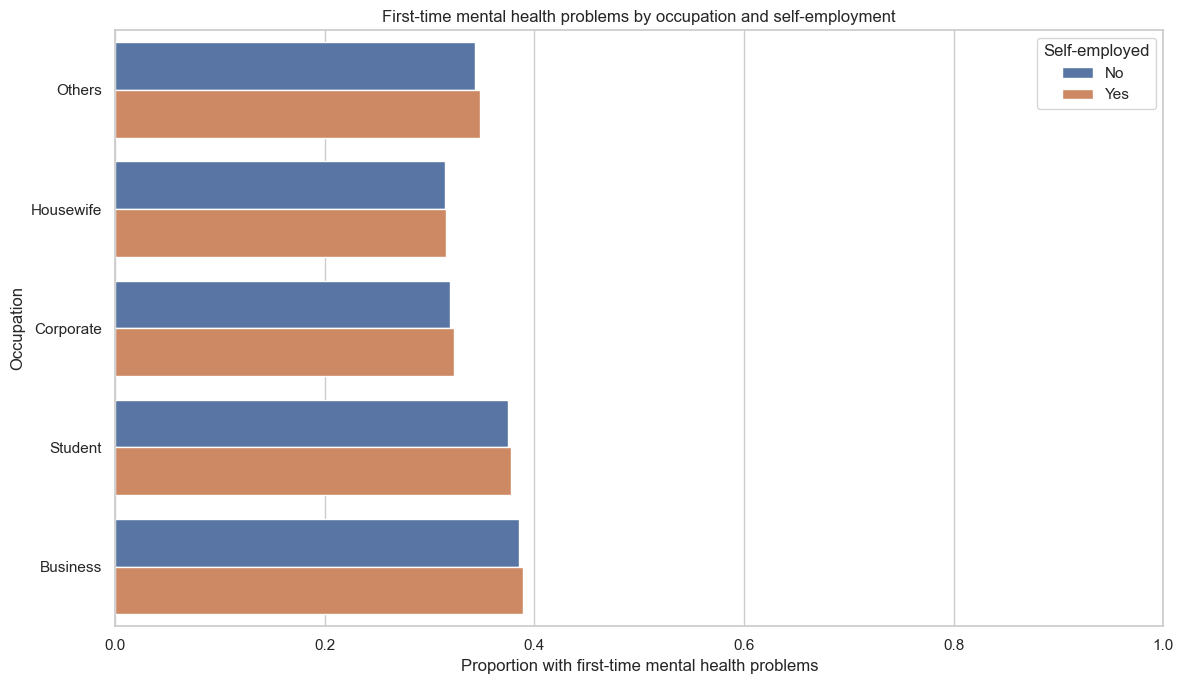

In [9]:
top_occ_for_plot = first_time_stats["Occupation"]

plot_df = df[df["Occupation"].isin(top_occ_for_plot)].copy()

plt.figure(figsize=(12, 7))
sns.barplot(
    data=plot_df,
    x="FirstTimeIssue_bin",
    y="Occupation",
    hue="SelfEmployed",
    ci=None,
    estimator=np.mean,
)
plt.xlabel("Proportion with first-time mental health problems")
plt.ylabel("Occupation")
plt.title("First-time mental health problems by occupation and self-employment")
plt.xlim(0, 1)
plt.legend(title="Self-employed")
plt.tight_layout()
plt.show()


In [12]:
# encode SelfEmployed and FamilyHistory as binary (Yes or Maybe vs No)
df["SelfEmployed_bin"] = yes_or_maybe_to_1(df["SelfEmployed"])
df["FamilyHistory_bin"] = yes_or_maybe_to_1(df["FamilyHistory"])

cluster_vars = [
    "SelfEmployed_bin",
    "FamilyHistory_bin",
    "DaysIndoors_num",
    "HabitsChange_bin",
    "MentalHealthHistory_bin",
    "IncreasingStress_bin",
    "SocialWeakness_bin",
    "MoodSwings_bin",
]

cluster_df = df.dropna(subset=cluster_vars).copy()  # drop any rows missing these
X = cluster_df[cluster_vars].values

# standardize features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
n_classes = 4  # try 3, 4, or 5 and see which is most interpretable

gmm = GaussianMixture(n_components=n_classes, random_state=42)
cluster_labels = gmm.fit_predict(X_scaled)

cluster_df["LatentClass"] = cluster_labels

/Users/Daniela.Valdez/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/Daniela.Valdez/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/Daniela.Valdez/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/Daniela.Valdez/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/Daniela.Valdez/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/Daniela.Valdez/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sa

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# make sure these columns exist in df:
cluster_vars = [
    "SelfEmployed_bin",
    "FamilyHistory_bin",
    "DaysIndoors_num",
    "HabitsChange_bin",
    "MentalHealthHistory_bin",
    "IncreasingStress_bin",
    "SocialWeakness_bin",
    "MoodSwings_bin",
]

# 1. keep only those columns, drop rows with missing values
cluster_df = df[cluster_vars + ["Occupation"]].copy()  # keep Occupation for plotting later
cluster_df = cluster_df.replace([np.inf, -np.inf], np.nan)
cluster_df = cluster_df.dropna(subset=cluster_vars)

# 2. ensure everything is numeric
for col in cluster_vars:
    cluster_df[col] = pd.to_numeric(cluster_df[col], errors="coerce")

cluster_df = cluster_df.dropna(subset=cluster_vars)

X = cluster_df[cluster_vars].to_numpy(dtype=float)

print("Cluster matrix shape:", X.shape)
print("Any NaNs left?", np.isnan(X).any())
print("Min / max values:", np.nanmin(X), np.nanmax(X))

Cluster matrix shape: (236178, 8)
Any NaNs left? False
Min / max values: 0.0 4.0


In [15]:
# scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# fit GaussianMixture as latent classes
n_classes = 4  # you can tweak this (3–5 usually)
gmm = GaussianMixture(
    n_components=n_classes,
    random_state=42,
    covariance_type="full",
    reg_covar=1e-6,    # regularization for numerical stability
    init_params="random"  # avoid k-means initialization (no kmeans warnings)
)

cluster_labels = gmm.fit_predict(X_scaled)

cluster_df["LatentClass"] = cluster_labels
cluster_df["LatentClass"].value_counts()

LatentClass
2    212514
0     22284
3      1036
1       344
Name: count, dtype: int64

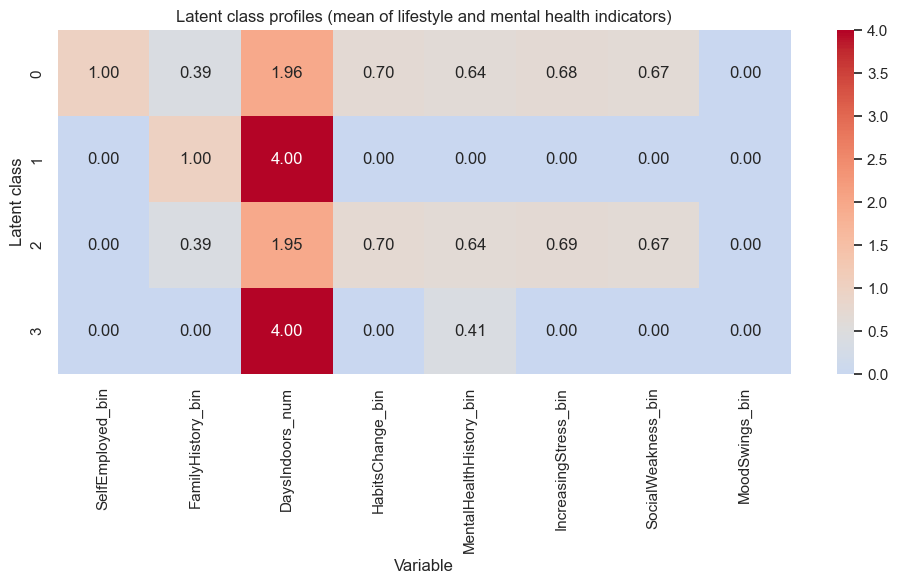

In [16]:
cluster_profile = (
    cluster_df.groupby("LatentClass")[cluster_vars]
    .mean()
    .sort_index()
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    cluster_profile,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0.5,
)
plt.title("Latent class profiles (mean of lifestyle and mental health indicators)")
plt.xlabel("Variable")
plt.ylabel("Latent class")
plt.tight_layout()
plt.show()

In [17]:
cluster_occ = cluster_df[["Occupation", "LatentClass"]].copy()

# keep occupations that appear often (to avoid super noisy tiny groups)
occ_counts = cluster_occ["Occupation"].value_counts()
occ_keep = occ_counts[occ_counts > 1000].index  # adjust threshold if you want

cluster_occ_filtered = cluster_occ[cluster_occ["Occupation"].isin(occ_keep)]

cluster_occ_prop = (
    cluster_occ_filtered
    .groupby(["Occupation", "LatentClass"])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .reset_index(name="Proportion")
)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=cluster_occ_prop,
    x="Proportion",
    y="Occupation",
    hue="LatentClass",
)
plt.xlabel("Proportion of latent class within occupation")
plt.ylabel("Occupation")
plt.title("Distribution of latent classes across occupations")
plt.xlim(0, 1)
plt.legend(title="Latent class")
plt.tight_layout()
plt.show()

ValueError: cannot insert Occupation, already exists

In [18]:
cluster_occ = cluster_df[["Occupation", "LatentClass"]].copy()

In [19]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# columns to use in latent class analysis
cluster_vars = [
    "SelfEmployed_bin",
    "FamilyHistory_bin",
    "DaysIndoors_num",
    "HabitsChange_bin",
    "MentalHealthHistory_bin",
    "IncreasingStress_bin",
    "SocialWeakness_bin",
    "MoodSwings_bin",
]

# start from the main df so we know Occupation is there
cluster_data = df[cluster_vars + ["Occupation"]].copy()

# clean infinities / NaNs
cluster_data = cluster_data.replace([np.inf, -np.inf], np.nan)
cluster_data = cluster_data.dropna(subset=cluster_vars)

# ensure numeric
for col in cluster_vars:
    cluster_data[col] = pd.to_numeric(cluster_data[col], errors="coerce")

cluster_data = cluster_data.dropna(subset=cluster_vars)

X = cluster_data[cluster_vars].to_numpy(dtype=float)

print("Cluster matrix shape:", X.shape)
print("Any NaNs left?", np.isnan(X).any())

Cluster matrix shape: (236178, 8)
Any NaNs left? False


In [20]:
# scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# latent classes
n_classes = 4  # tweak if you want
gmm = GaussianMixture(
    n_components=n_classes,
    random_state=42,
    covariance_type="full",
    reg_covar=1e-6,
    init_params="random",  # avoids k-means initialization issues
)

cluster_labels = gmm.fit_predict(X_scaled)

# attach labels back to cluster_data
cluster_data["LatentClass"] = cluster_labels

cluster_data["LatentClass"].value_counts()


LatentClass
2    212514
0     22284
3      1036
1       344
Name: count, dtype: int64

In [21]:
cluster_occ = cluster_data[["Occupation", "LatentClass"]].copy()

# keep only occupations with enough rows to be meaningful
occ_counts = cluster_occ["Occupation"].value_counts()
occ_keep = occ_counts[occ_counts > 1000].index  # adjust threshold as needed

cluster_occ_filtered = cluster_occ[cluster_occ["Occupation"].isin(occ_keep)]

cluster_occ_prop = (
    cluster_occ_filtered
    .groupby(["Occupation", "LatentClass"])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .reset_index(name="Proportion")
)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=cluster_occ_prop,
    x="Proportion",
    y="Occupation",
    hue="LatentClass",
)
plt.xlabel("Proportion of latent class within occupation")
plt.ylabel("Occupation")
plt.title("Distribution of latent classes across occupations")
plt.xlim(0, 1)
plt.legend(title="Latent class")
plt.tight_layout()
plt.show()


ValueError: cannot insert Occupation, already exists